# Reliability: computation of failure of probability via Subset Simulation

This example file demonstrates how to compute a probability of failure using Subset Simulation using UQpy (SubsetSimulation class). The computational model consists in an Abaqus model of a beam subjected to mechanical and fire loads - see **section 5.2** in the accompanying paper "UQpy: A general purpose Python package and development environment for uncertainty quantification".  

First, the use of the SubsetSimulation and RunModel classes is illustrated using a few samples. The files necessary to run this example are:
1. The input template - 'abaqus_input_subset_sfe.py'
2. The model script - 'abaqus_subset_sfe_model_script.py'
3. The output script - 'extract_abaqus_output_subset_sfe.py'
4. The script used by the output script - 'abaqus_output_script.py'

Note: To execute the example in this notebook, it is necessary to have access to the finite element solver Abaqus.

The same problem was run with a larger number of samples on the MARCC cluster, the last cell in this notebook shows the results.

### The model

Import the python modules used in this example, note down the start time and the current directory, which will be used later to save the results.

In [1]:
from UQpy.Reliability import SubsetSimulation
import matplotlib.pyplot as plt
from UQpy.SampleMethods import MCMC, MMH
from UQpy.Distributions import MVNormal
from UQpy.RunModel import RunModel
import numpy as np
import glob
import pickle
import os
import math
import time

calling_directory = os.getcwd()
t = time.time()

There are two probabilistic input variables, the fire load density and the yield strength. The fire load density is denoted as 'qtd' and the yield strength is denoted as 'fy' in the template input script. These are different from the default variable names used by RunModel, and hence they must be passed in as one of the inputs while building the RunModel object.

In [2]:
var_names = ['qtd', 'fy']

In [3]:
abaqus_sfe_model = RunModel(model_script='abaqus_subset_sfe_model_script.py',
                            input_template='abaqus_input_subset_sfe.py',
                            output_script='extract_abaqus_output_subset_sfe.py',
                            var_names=var_names, model_dir='Subset_SFE')
print('Example: Created the model object.')

Example: Created the model object.


### Perform subset simulation

This is done for illustration purposes only with a few samples.

The subset simulation algorithm operates in the standard normal space. So, the input template to the RunModel object has been modified to accept samples from standard normal random variables and transform it to have the desired distribution. The MCMC object needs the target distribution and proposal distribution to be specified, which is done next.

In [4]:
# Specify the target distribution. This is standard normal for use with subset simulation in UQpy.
dist = MVNormal(mean=np.zeros(2), cov=np.eye(2))

# Define the initial samples from the distribution
x = dist.rvs(nsamples=10, random_state=834765)

In [5]:
# Run Subset Simulation
x_ss = SubsetSimulation(mcmc_class=MMH, runmodel_object=abaqus_sfe_model, samples_init=x, p_cond=0.5,
                        nsamples_per_ss=10, verbose=True, random_state=923457, log_pdf_target=dist.log_pdf,
                        dimension=2, nchains=5)

# Save the results in a dictionary
results = {'pf': x_ss.pf, 'cov': x_ss.cov1, 'samples': x_ss.samples, 'g': x_ss.g, 'qois':x_ss.runmodel_object.qoi_list}

UQpy: Running Subset Simulation with MCMC of type: <class 'UQpy.SampleMethods.MMH'>
UQpy: Subset Simulation, conditional level 0 complete.
UQpy: Subset Simulation, conditional level 1 complete.
UQpy: Subset Simulation, conditional level 2 complete.
UQpy: Subset Simulation, conditional level 3 complete.
UQpy: Subset Simulation, conditional level 4 complete.
UQpy: Subset Simulation Complete!


Probability of failure:  0.0625
Cov:  0.9718253158075502


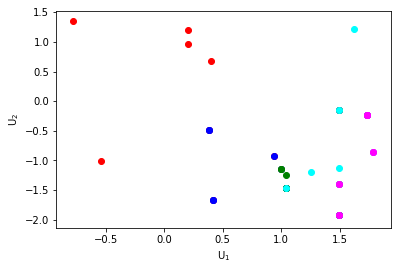

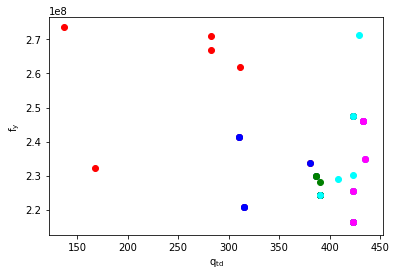

Example: Done!
Time elapsed: 18.76 minutes


In [6]:
results = {'pf': x_ss.pf, 'cov': x_ss.cov1, 'samples': x_ss.samples, 'g': x_ss.g, 'qois':x_ss.runmodel_object.qoi_list}

# Load the results from the latest pickle dump.
colors = ['red', 'blue', 'green', 'cyan', 'magenta', 'yellow', 'black']
# Display the results
pf = results['pf']
cov = results['cov']
print('Probability of failure: ', pf)
print('Cov: ', cov)

qois = results['qois']

samples = results['samples']
# Plot the results
for i in range(len(samples)):
    plt.scatter(samples[i][:, 0], samples[i][:, 1], color=colors[i], marker='o')
plt.xlabel('$\mathregular{U_1}$')
plt.ylabel('$\mathregular{U_2}$')
plt.show()


# Transform the random variable
def phi(x=0):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0


# Plot the results - samples converted to values used
for i in range(len(samples)):
    q = [50 + 400 * phi(x) for x in samples[i][:, 0]]
    f = samples[i][:, 1] * 0.07 * 250e6 + 250e6
    plt.scatter(q, f, color=colors[i], marker='o')
plt.xlabel('$\mathregular{q_{td}}$')
plt.ylabel('$\mathregular{f_y}$')
plt.show()

print('Example: Done!')
print('Time elapsed: %.2f minutes' % float((time.time() - t) / 60.0))

### Load results from a larger number of runs (computations were performed on MARCC).

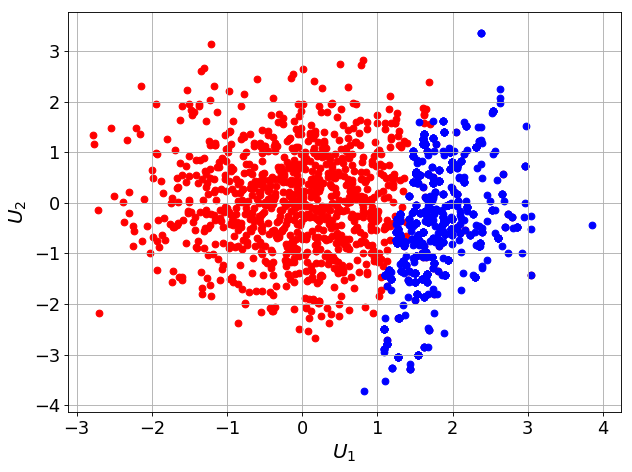

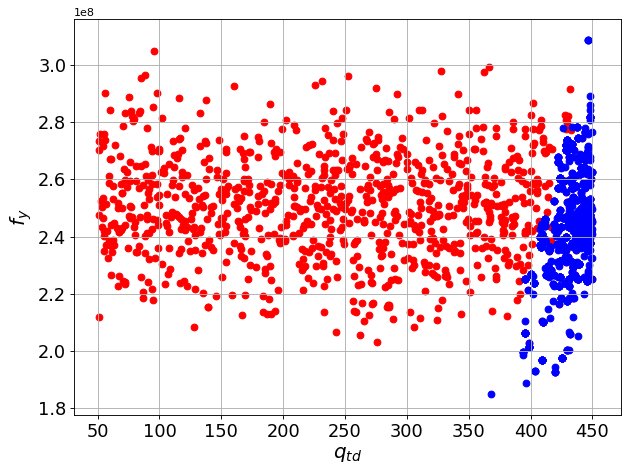

In [7]:
res_file_name = 'Subset_sfe_results_002.pkl'
# Load the results from the latest pickle dump.
with open(res_file_name, 'rb') as f:
    results = pickle.load(f)
samples = results['samples']

colors = ['red', 'blue']
fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(samples)):
    plt.scatter(samples[i][:, 0], samples[i][:, 1], color=colors[i], marker='o')
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$U_1$', FontSize=18)
plt.ylabel(r'$U_2$', FontSize=18)
plt.tight_layout()
plt.show()

# Transform the random variable
def phi(x=0):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(samples)):
    q = [50 + 400 * phi(x) for x in samples[i][:, 0]]
    f = samples[i][:, 1] * 0.07 * 250e6 + 250e6
    plt.scatter(q, f, color=colors[i], marker='o')
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$q_{td}$', FontSize=18)
plt.ylabel(r'$f_y$', FontSize=18)
plt.tight_layout()
plt.show()